# Policy Gradient 

This Notebook reimplements Karpathy's basic policy gradient agent in PyTorch without GPU acceleration.

It is meant to be run on the laptop for code development. After code is stable, it will be translated to the AI Workstation with GPU acceleration for long training sessions.

In [4]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import random
import pickle as pickle
import pympler
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.3


In [ ]:
env.close()

## Karpathy Basic Policy Gradient "Pong"

The following code uses a REINFORCE policy gradient method to train a 2 layer NN to play Pong.

The time needed to train 10 episodes is 13 sec with CPU.

The forward pass takes 4 seconds. So implementing this in PyTorch and using GPU will speed things up by 30%.

In [3]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
verbose = False
print_every = 20
reward_sum = 0
episode_number = 0
forward_time=0
backward_time=0
other_time=0

start = time.time()

while episode_number < 1000:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  t1 = time.time()
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
  t2 = time.time()
  forward_time += t2-t1

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken 
  # (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  t5 = time.time()  
  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  t6 = time.time()
  other_time += t6-t5

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    
    t3 = time.time()    
    grad = policy_backward(eph, epdlogp)
    t4 = time.time()
    backward_time += t4-t3    
    
    for k in model: 
        grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % print_every == 0:     
        print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

    epoch_reward_history.append([reward_sum, running_reward])
    if episode_number % 100 == 0: pickle.dump(model, open('save-cpu-lr1e-3-1000ep.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
    print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
end = time.time()
print ("Time to complete", end-start)
print ("Time to forward pass", forward_time)
print ("Time to backward pass", backward_time)
print ("Time to other stuffs", other_time)

Episode 20 - reward total was -21.000000. running mean: -20.964255
Episode 40 - reward total was -21.000000. running mean: -20.840709
Episode 60 - reward total was -20.000000. running mean: -20.752657
Episode 80 - reward total was -20.000000. running mean: -20.652472
Episode 100 - reward total was -21.000000. running mean: -20.499510
Episode 120 - reward total was -19.000000. running mean: -20.352835
Episode 140 - reward total was -21.000000. running mean: -20.343211
Episode 160 - reward total was -20.000000. running mean: -20.267170
Episode 180 - reward total was -21.000000. running mean: -20.196141
Episode 200 - reward total was -18.000000. running mean: -20.157837
Episode 220 - reward total was -19.000000. running mean: -20.119638
Episode 240 - reward total was -21.000000. running mean: -20.131668
Episode 260 - reward total was -21.000000. running mean: -20.177770
Episode 280 - reward total was -20.000000. running mean: -20.144430
Episode 300 - reward total was -19.000000. running m

### Observations (Laptop CPU)

Time to train 1000 episodes is 2400 seconds or 40 minutes. Over 1100 seconds are consumed by OpenAI Gym stepping through its environment (1 second per step).  

The agent achieved under -19.0 running reward and highs of -13 reward sum after 1000 episodes.

The trained model is in save-cpu-lr1e-3-1000ep.p



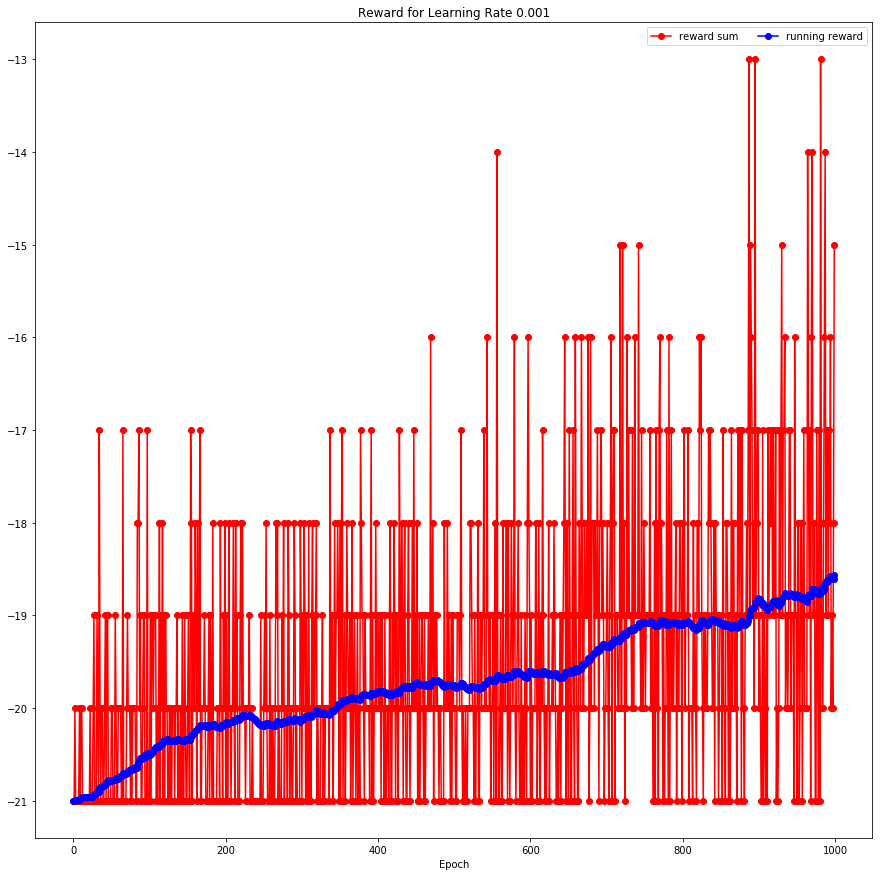

In [4]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(learning_rate))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

### Variability of Training

How well a model train is variable. For the training session below, the agent achieved close to -16 running reward and highs of -6 reward sum after the same 1000 episodes, which is much better than the training session before it.

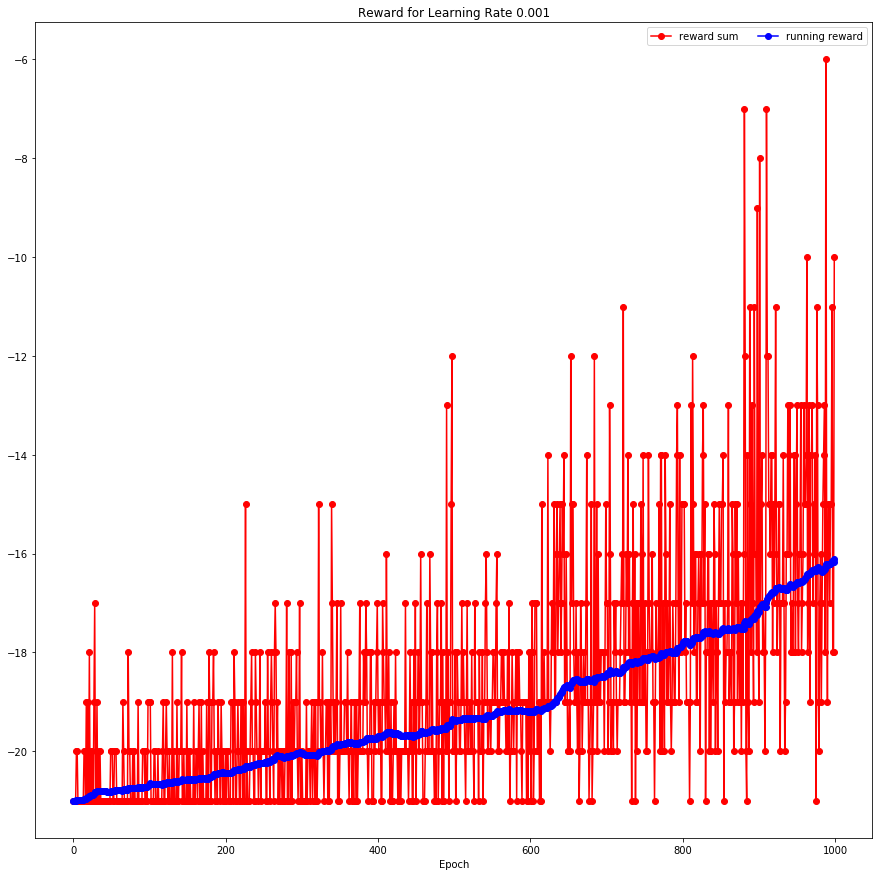

In [262]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(learning_rate))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

pickle.dump(model, open('reward_lr_1e-3_1000ep_numpy.p', 'wb'))

## PyTorch - Policy Gradient on Cartpole

The following code is PyTorch's official example for REINFORCE Policy Gradient. It trains a RL agent to master the simple game of Cartpole: 

https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

The pseudo-code for REINFORCE is as followed:

```
# REINFORCE Pseudo-Code
function REINFORCE
    Initialise θ arbitrarily
    for each episode {s_1 , a_1 , r_2 , ... , s_T−1 , a_T−1 , r_T }~ π_θ do
        for t = 1 to T − 1 do
            θ ← θ + α ∇_θ log (π_θ ( s_t , a_t ) )v_t
    return θ
```

where  
* π_θ is the policy
* v_t is the sample of Q_π_θ(s_t, a_t)
* ∇_θ log ( π_θ ( s_t , a_t ) ) is the score function or log_prob

In [8]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
log_interval=50
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make('CartPole-v0')
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of CartPole, which consists of 4 readings.
# - The action is the softmax output (Left or Right)
# - there are 128 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def select_action(state):
    """ 
    Use Policy to select an action based on state returned by CartPole
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("This is CartPole's state output:", state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state))
    if verbose:
        print ("This is softmax output from NN:", probs)

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Action sampled:", action, action.data[0])
        print ("log_prob(action) saved by policy:", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    return action.data[0]  # return the action sampled


def finish_episode():
    """ 
    Based on REINFORCE, policy gradient is calculated at the end of an episode.
    It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]
    
    return policy_loss.data[0]


# Main loop
running_reward = 10
for i_episode in count(1):  # Infinite loop
# for i_episode in range(1): # just run 1 episode    
    state = env.reset()
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        # break if episode is done
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01   # calculate running reward
    
    # Calculate policy gradient and update Policy 
    loss = finish_episode()
    
    reinforce.append([t, running_reward, loss/t])
    
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}\tLoss: {:.2f}'.format(
                i_episode, t, running_reward, loss/t))
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
        break


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 50	Last length:    28	Average length: 10.84	Loss: 0.03
Episode 100	Last length:    42	Average length: 20.58	Loss: -0.04
Episode 150	Last length:    72	Average length: 30.69	Loss: 0.04
Episode 200	Last length:    40	Average length: 41.11	Loss: -0.03
Episode 250	Last length:    74	Average length: 39.69	Loss: 0.13
Episode 300	Last length:   132	Average length: 52.62	Loss: 0.04
Episode 350	Last length:   108	Average length: 69.47	Loss: 0.01
Episode 400	Last length:    85	Average length: 79.72	Loss: 0.04
Episode 450	Last length:   171	Average length: 108.03	Loss: 0.03
Episode 500	Last length:   199	Average length: 143.93	Loss: -0.01
Episode 550	Last length:   199	Average length: 165.50	Loss: -0.04
Episode 600	Last length:   199	Average length: 178.73	Loss: -0.01
Episode 650	Last length:   199	Average length: 186.74	Loss: -0.11
Episode 700	Last length:   124	Average length: 187.69	Loss:

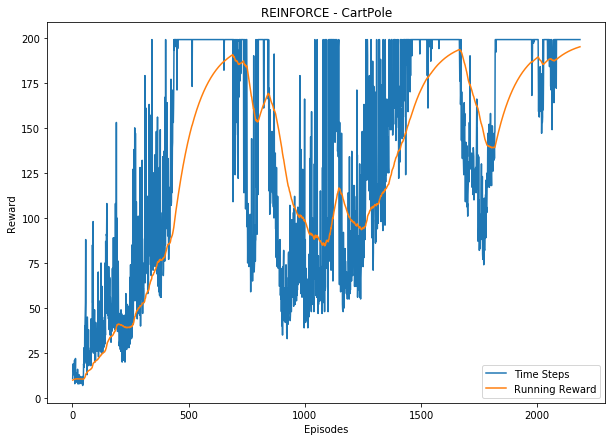

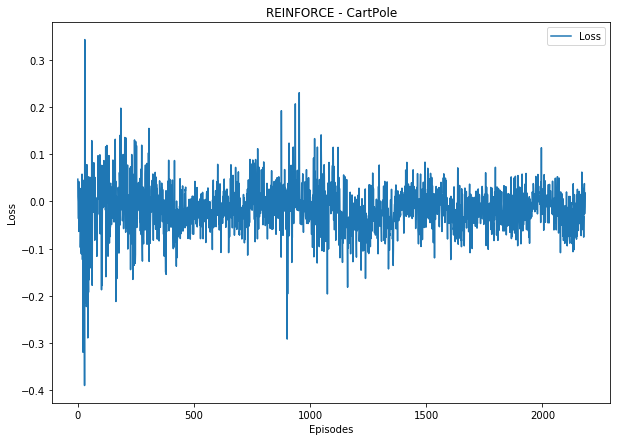

In [9]:
# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,0])+1)), np.array(reinforce)[:,0], label='Time Steps')
plt.plot(list(range(1,len(np.array(reinforce)[:,1])+1)), np.array(reinforce)[:,1], label='Running Reward')
plt.title('REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,2])+1)), np.array(reinforce)[:,2], label='Loss')
plt.title('REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.show()

## PyTorch - Actor-Critic on Cartpole

The following code is PyTorch's official example for Actor-Critic Policy Gradient. It trains a RL agent to master the simple game of Cartpole: 

https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py

The pseudo-code for ACTOR-CRITIC is as followed:

```
# Q Actor-Critic Pseudo-Code
    function QAC
    Initialise s, θ
    Sample a ∼ π_θ # sample an action
    for each step do
        Sample reward r = R_sa ; sample transition s′ = P_sa ;
        # sample next action according to our policy
        Sample action a′ ~ π_θ(s′, a′)
        δ = r + γQ_w(s′, a′) − Q_w(s, a) # get TD error
        θ = θ + α∇_θ log π_θ(s, a)Q_w(s, a) # update actor policy
        w ← w + βδ∅(s, a)
        # update critic
        a ← a′ , s ← s′
```

where  
* π_θ is the policy
* v_t is the sample of Q_π_θ(s_t, a_t)
* ∇_θ log ( π_θ ( s_t , a_t ) ) is the score function or log_prob

In [18]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=1
render=False
log_interval=50
verbose=False  # To step through the code and understand what is going on

actorCritic=[]

env = gym.make('CartPole-v0')
env.seed(seed)
torch.manual_seed(seed)

# This is saved as a list and used to update the Actor and Critic's parameters
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# The function approximators for the Actor and the Critic is ia a two 2-layer NN with 2 heads
# - the NN takes in the state of CartPole, which consists of 4 readings.
# - there are 128 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

# Call an instance of the Policy and select ADAM as update rule
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)

def select_action(state):
    """ 
    Use Policy to select an action based on state returned by CartPole
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]   # return sampled action


def finish_episode():
    """ 
    In this implementation, Actor and Critic parameters are updated at the end of an episode.
    """

    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []     # This is v_t
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in model.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    # Calculate gradient for Actor and Critic
    for (log_prob, value), r in zip(saved_actions, rewards):
        # Actor's policy gradient is computed here
        reward = r - value.data[0]   
        policy_losses.append(-log_prob * reward)
        
        # Critic's value gradient is computed here
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]))))

    optimizer.zero_grad()# zero the gradients before running the optimizer
    
    # Sum Actor and Critic gradients for all time steps in the episode
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # The TRICK: backward() on loss instead of policy
    # Actor's and Critic's parameters are updated here.
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]


# Main Loop
running_reward = 10
for i_episode in count(1):
    state = env.reset()
    for t in range(10000):  # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        if render:
            env.render()
        model.rewards.append(reward)
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01
    finish_episode()
    
    actorCritic.append([t, running_reward])
    
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_episode, t, running_reward))
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
        break



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 50	Last length:    48	Average length: 34.00
Episode 100	Last length:   136	Average length: 56.87
Episode 150	Last length:   199	Average length: 84.54
Episode 200	Last length:    71	Average length: 71.54
Episode 250	Last length:    91	Average length: 74.32
Episode 300	Last length:   131	Average length: 101.30
Episode 350	Last length:   165	Average length: 128.76
Episode 400	Last length:   199	Average length: 147.89
Episode 450	Last length:    14	Average length: 130.50
Episode 500	Last length:   199	Average length: 130.88
Episode 550	Last length:   197	Average length: 124.19
Episode 600	Last length:   199	Average length: 142.17
Episode 650	Last length:   162	Average length: 159.47
Episode 700	Last length:   132	Average length: 149.71
Episode 750	Last length:   199	Average length: 158.56
Episode 800	Last length:   199	Average length: 174.54
Episode 850	Last length:   199	Average leng

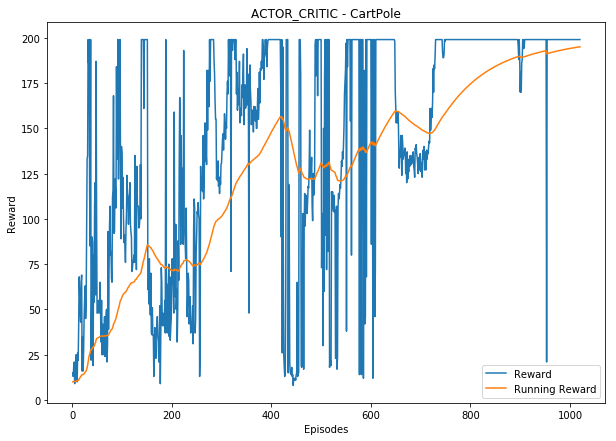

In [19]:
# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(actorCritic)[:,0])+1)), np.array(actorCritic)[:,0], label='Reward')
plt.plot(list(range(1,len(np.array(actorCritic)[:,1])+1)), np.array(actorCritic)[:,1], label='Running Reward')
plt.title('ACTOR_CRITIC - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()

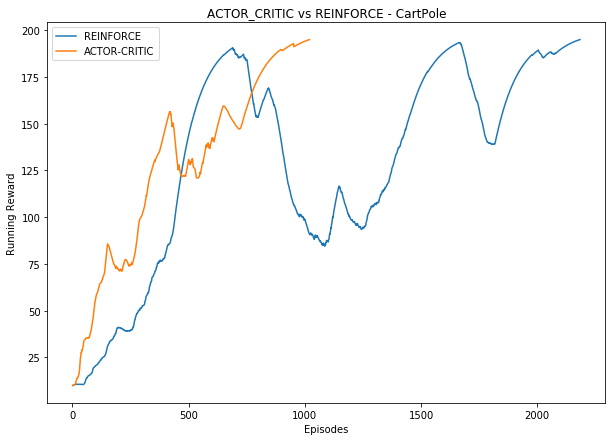

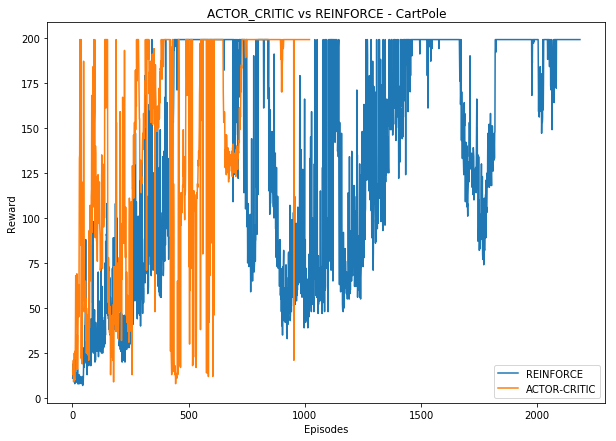

In [22]:
# Plot out running rewards of Actor-Critic vs REINFORCE
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,1])+1)), np.array(reinforce)[:,1], label='REINFORCE')
plt.plot(list(range(1,len(np.array(actorCritic)[:,1])+1)), np.array(actorCritic)[:,1], label='ACTOR-CRITIC')
plt.title('ACTOR_CRITIC vs REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Running Reward')
plt.legend()
plt.show()

# Plot out rewards of Actor-Critic vs REINFORCE
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,0])+1)), np.array(reinforce)[:,0], label='REINFORCE')
plt.plot(list(range(1,len(np.array(actorCritic)[:,0])+1)), np.array(actorCritic)[:,0], label='ACTOR-CRITIC')
plt.title('ACTOR_CRITIC vs REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()

## Apply REINFORCE on Pong

The code appears to be learning. But it is slow.


In [7]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
log_interval=1
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 80x80 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)


def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_episode():
    """ 
    Based on REINFORCE, policy gradient is calculated at the end of an episode.
    It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
prev_x = None
running_reward = -21

# for i_episode in count(1):  # Infinite loop
for i_episode in range(10): # just run 1 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x

        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        # break if episode is done
        if done:
            break
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
    # Calculate policy gradient and update Policy 
    finish_episode()
    
    reinforce.append([reward_sum, running_reward])
    
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
        
    if i_episode > 10000:
        print("Taking too long, Exit.")
        break    


Episode 0	Last Reward: -19.00	Running Reward: -20.98
Episode 1	Last Reward: -20.00	Running Reward: -20.97
Episode 2	Last Reward: -21.00	Running Reward: -20.97
Episode 3	Last Reward: -21.00	Running Reward: -20.97
Episode 4	Last Reward: -21.00	Running Reward: -20.97
Episode 5	Last Reward: -19.00	Running Reward: -20.95
Episode 6	Last Reward: -20.00	Running Reward: -20.94
Episode 7	Last Reward: -21.00	Running Reward: -20.94
Episode 8	Last Reward: -20.00	Running Reward: -20.93
Episode 9	Last Reward: -19.00	Running Reward: -20.91


## Apply ACTOR-CRITIC on Pong

Here we go...

In [2]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
log_interval=1
verbose=False  # To step through the code and understand what is going on

actorCritic=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# This is saved as a list and used to update the Actor and Critic's parameters
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# The function approximators for the Actor and the Critic is a 2-layer NN with 2 heads
# - The NN takes in the state of Pong, which is a resampled 80x80 image
# - there are 200 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.action_head = nn.Linear(200, 2)
        self.value_head = nn.Linear(200, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

# Call an instance of the Policy and select ADAM as update rule
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_episode():
    """ 
    In this implementation, Actor and Critic parameters are updated at the end of an episode.
    """

    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []     # This is v_t

    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in model.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    # Calculate gradient for Actor and Critic
    for (log_prob, value), r in zip(saved_actions, rewards):
        # Actor's policy gradient is computed here
        reward = r - value.data[0]   
        policy_losses.append(-log_prob * reward)
        
        # Critic's value gradient is computed here
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]))))

    optimizer.zero_grad()# zero the gradients before running the optimizer
    
    # Sum Actor and Critic gradients for all time steps in the episode
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # The TRICK: backward() on loss instead of policy
    # Actor's and Critic's parameters are updated here.
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]



# Main loop
prev_x = None
running_reward = -21

# for i_episode in count(1):  # Infinite loop
for i_episode in range(20): # just run 10 episode 
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x

        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        model.rewards.append(reward)
        
        # break if episode is done
        if done:
            break

    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
    # Calculate policy gradient and update Policy 
    finish_episode()
   
    actorCritic.append([reward_sum, running_reward])
     
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
        
    if i_episode > 10000:
        print("Taking too long, Exit.")
        break


Episode 0	Last Reward: -21.00	Running Reward: -21.00
Episode 1	Last Reward: -21.00	Running Reward: -21.00
Episode 2	Last Reward: -18.00	Running Reward: -20.97
Episode 3	Last Reward: -21.00	Running Reward: -20.97
Episode 4	Last Reward: -21.00	Running Reward: -20.97
Episode 5	Last Reward: -20.00	Running Reward: -20.96
Episode 6	Last Reward: -21.00	Running Reward: -20.96
Episode 7	Last Reward: -21.00	Running Reward: -20.96
Episode 8	Last Reward: -19.00	Running Reward: -20.94
Episode 9	Last Reward: -21.00	Running Reward: -20.94
Episode 10	Last Reward: -21.00	Running Reward: -20.94
Episode 11	Last Reward: -21.00	Running Reward: -20.94
Episode 12	Last Reward: -21.00	Running Reward: -20.94
Episode 13	Last Reward: -18.00	Running Reward: -20.91
Episode 14	Last Reward: -17.00	Running Reward: -20.88
Episode 15	Last Reward: -21.00	Running Reward: -20.88
Episode 16	Last Reward: -19.00	Running Reward: -20.86
Episode 17	Last Reward: -19.00	Running Reward: -20.84
Episode 18	Last Reward: -21.00	Running

# Misc

In [ ]:
from time import sleep

env = gym.make("Pong-v0")

for i_episode in range(1): # just run 1 episode    
    state = env.reset()
    
    for t in range(10000):  # Don't infinite loop while learning
      
        # step the environment through the action
        state, reward, done, _ = env.step(3)
        env.render()
        sleep(0.02)    
        
env.close()


In [164]:
print (x_tensor.size())
xs = torch.cat((x_tensor.view(1,-1), x_tensor.view(1,-1)),0)
print (xs.size())

torch.Size([6400, 1])
torch.Size([2, 6400])


In [186]:
print(I.view(-1,1))

RuntimeError: invalid argument 2: input is not contiguous at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCTensor.c:227

In [217]:
dlogps_tensor = torch.zeros(1, 1).type(dtype)
dlogps_tensor[0,0] = 5

print(dlogps_tensor)
        
drs_tensor = torch.zeros(1, 1).type(dtype)
drs_tensor [0,0] = 1
print(drs_tensor)        
        
a = torch.zeros(1, 1).type(dtype)
a[0,0] = 7
print(a)
dlogps_tensor = torch.cat((dlogps_tensor, dlogps_tensor),0) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
print(dlogps_tensor)

a[0,0] = -1 
drs_tensor = torch.cat((drs_tensor, a),0) # record reward (has to be done after we call step() to get reward for previous action)
print(drs_tensor)


 5
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 1
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 7
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 5
 5
[torch.cuda.FloatTensor of size 2x1 (GPU 0)]


 1
-1
[torch.cuda.FloatTensor of size 2x1 (GPU 0)]



In [271]:
# hyperparameters
H = 200 # number of hidden layer neurons
D = 80 * 80 # input dimensionality: 80x80 grid

model = {}
model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
model['W2'] = np.random.randn(H) / np.sqrt(H)

print (model['W1'].shape)
print (model['W2'].shape)

(200, 6400)
(200,)


In [3]:
data = pickle.load(open('./results/actor-critic/pong_ep=20000history.p', 'rb'))

In [47]:
"""
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine1_bn = nn.BatchNorm1d(200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1_bn(self.affine1(x)))
        return x
#         action_scores = self.affine2(x)
#        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
model = Policy()
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense1 = nn.Linear(in_features=320, out_features=50)
        self.dense1_bn = nn.BatchNorm1d(50)
        self.dense2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.dense1_bn(self.dense1(x)))
        # x = F.relu(self.dense2(x))
        # return F.log_softmax(x)
        return x


In [49]:
model = Net()

print (model)
    
x = torch.randn(5,320)
x_var = Variable(x) # Construct a PyTorch Variable out of your input data
ans = model(x_var)        # Feed it through the model! 

print (ans.shape)

Net(
  (dense1): Linear(in_features=320, out_features=50)
  (dense1_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  (dense2): Linear(in_features=50, out_features=10)
)
torch.Size([5, 50])
